# Lomb-Scargle periodogram
In this notebook we are going to analyse the time-series in a test-dataset using periodograms. There are meant to capture seasonality in time-series, let's dive into it.

## Load data

In [1]:
import pickle
with open(f"../../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
data_obs = data['data']
meta_obs = data['meta']

## Periodograms
Let's look how the frequencies band affect the results that one get. Also, we want to understand which kind of seasonality exists in our data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle, find_peaks

In [3]:
# frequency band: time in days to make it more understandable.
#freq = np.linspace(0.2/365, 10/365, 1000) #(cycles per day) / 365 to convert to cycles per year
freq = np.linspace(0.7/365, 2/365, 1000)
freq_angular = 2 * np.pi * freq  # angular frequencies that's how the function requires it)
k_peaks = 3  # number of peaks to detect

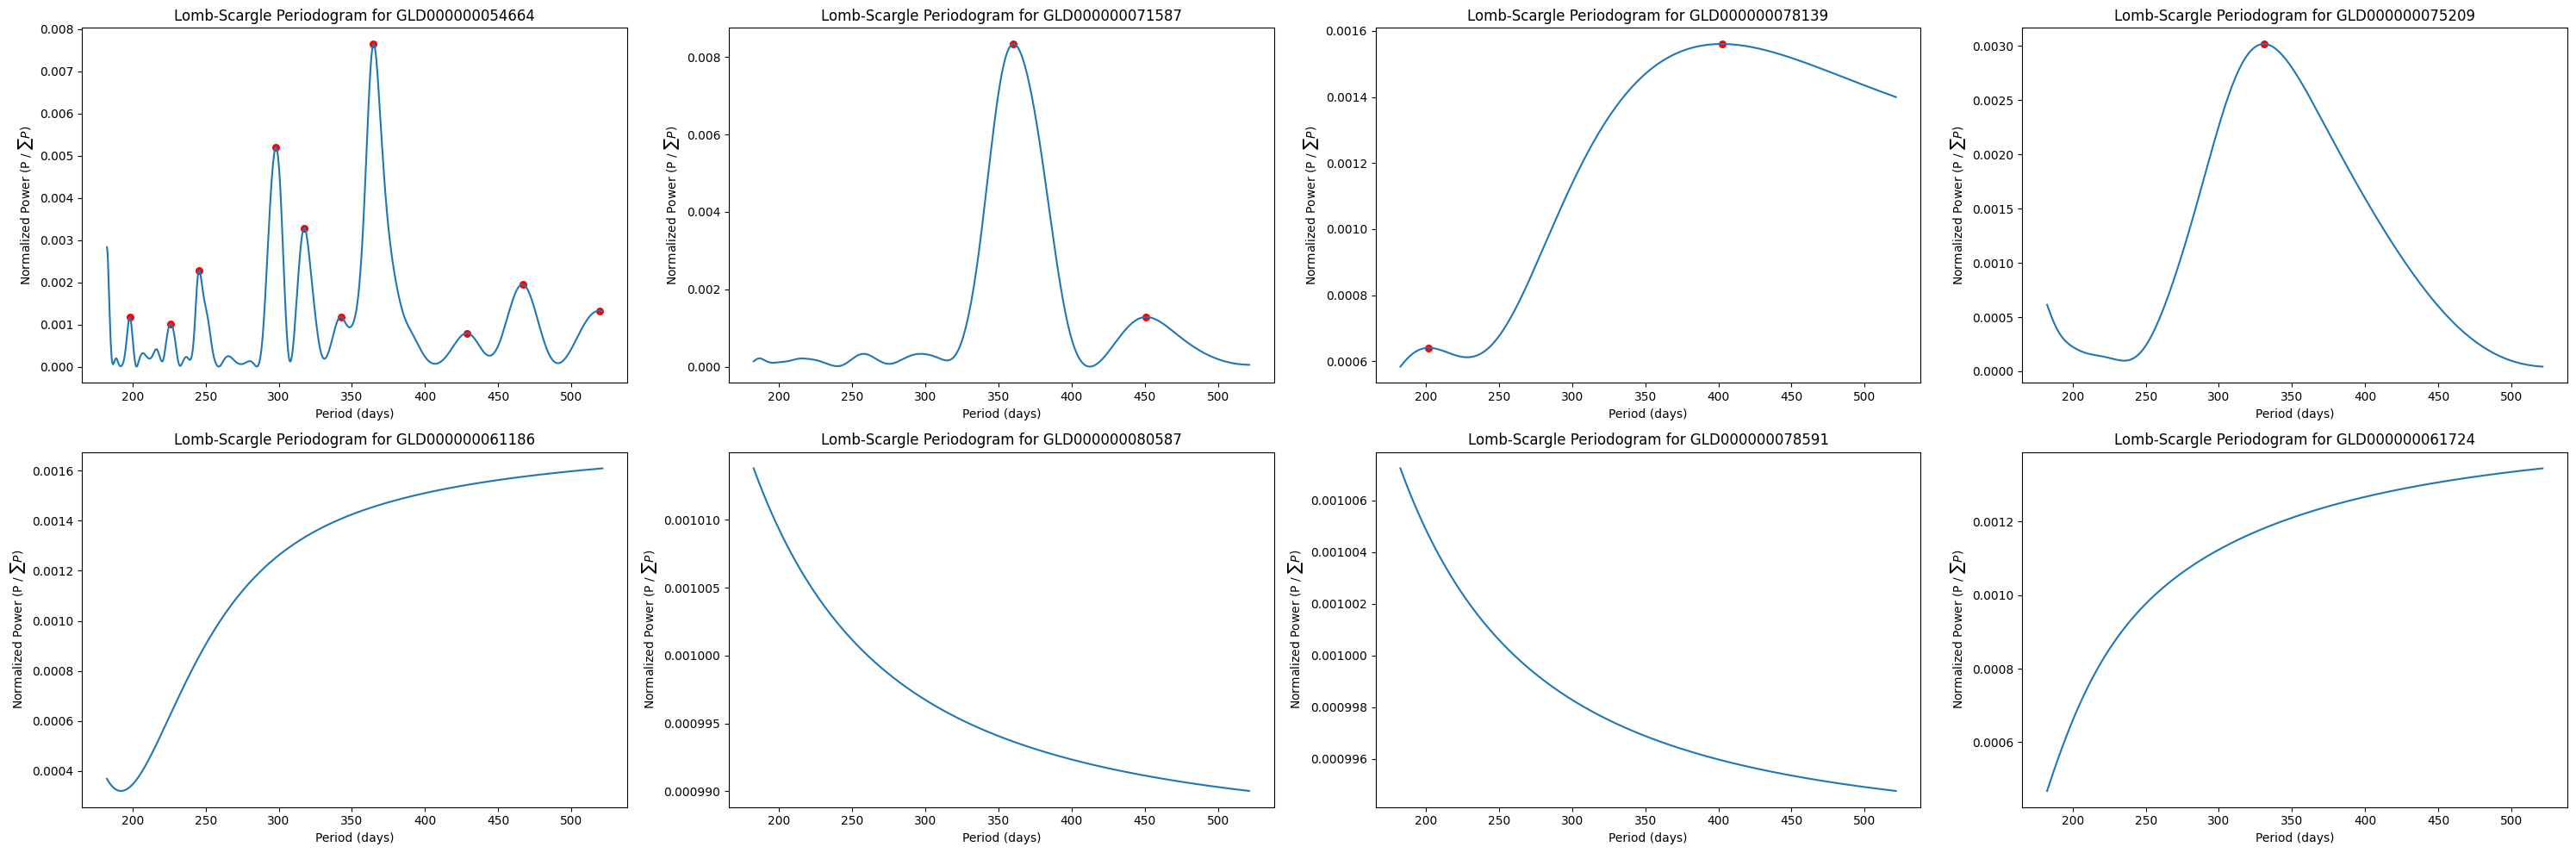

In [4]:
# Loop trough the data
num_plots = 4
p, p_no_pgram = 0, 0 
fig, axes = plt.subplots(2, num_plots, figsize=(30, 10))
pgram_data = []
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    # normalization (is it needed?)
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    times_days = (dino_ts[:, 0] - dino_ts[0, 0]) / 1000 / 86400  # convert from unix ms to days, start at 0
    pgram = lombscargle(times_days, dino_ts[:, 1], freq_angular) # frequencies are angular
    p_max = pgram.max()
    if p_max <= 0: continue # skip periodograms with no power (no seasonality)
    p_norm = pgram / np.sum(pgram)
    p_rel = pgram / p_max
    
    # Peak detection
    peaks, _ = find_peaks(pgram, height=p_max*0.1)  # peaks higher than 10% of max
    peak_periods = 1 / freq[peaks]
    num_peaks = len(peaks)
    if num_peaks > 0: # > 0 skip periodograms with no power (no seasonality)
        order = np.argsort(pgram[peaks])[::-1]
        row = {'GLD': gld}
        row['dominance'] = p_norm[order[0]] / (p_norm[order[:min(5, num_peaks)]].sum() + 1e-12)
        row['num_peaks'] = num_peaks
        for k, j in enumerate(order[:k_peaks]):
            #print(f"{gld} Peak: period = {peak_periods[j]:.1f} days, power = {pgram[peaks[j]]:.3f}, normalized power: {p_norm[peaks[j]]:.3f}")
            row[f'period_{k+1}'] = peak_periods[j] # period (days)
            row[f'p_norm_peak_{k+1}'] = p_norm[peaks[j]]
            row[f'p_rel_peak_{k+1}'] = p_rel[peaks[j]]
        pgram_data.append(row)
    
        if p < num_plots:
            ax = axes[0, p]
            p += 1
            ax.scatter(peak_periods, p_norm[peaks], color='r', s=30, label='peaks')
            ax.plot(1/freq, p_norm)
            ax.set_title(f'Lomb-Scargle Periodogram for {gld}')
            ax.set_xlabel('Period (days)')
            ax.set_ylabel('Normalized Power (P / $\\sum{P}$)')
    else:
        if p_no_pgram < num_plots:
            ax = axes[1, p_no_pgram]
            p_no_pgram += 1
            ax.scatter(peak_periods, p_norm[peaks], color='r', s=30, label='peaks')
            ax.plot(1/freq, p_norm)
            ax.set_title(f'Lomb-Scargle Periodogram for {gld}')
            ax.set_xlabel('Period (days)')
            ax.set_ylabel('Normalized Power (P / $\\sum{P}$)')
plt.tight_layout();

In [5]:
pgram_df = pd.DataFrame(pgram_data).set_index('GLD')
pgram_df.head()

,dominance,num_peaks,period_1,p_norm_peak_1,p_rel_peak_1,period_2,p_norm_peak_2,p_rel_peak_2,period_3,p_norm_peak_3,p_rel_peak_3
GLD,,,,,,,,,,,
GLD000000054664,0.203791,10,364.780912,0.007646,1.0,298.099248,0.005194,0.679294,317.322252,0.003281,0.429054
GLD000000071587,0.504808,2,360.097768,0.008339,1.0,451.001855,0.001282,0.153745,NaN,NaN,NaN
GLD000000078139,0.499725,2,402.466887,0.001560,1.0,201.946721,0.000641,0.410630,NaN,NaN,NaN
GLD000000075209,1.000000,1,330.794702,0.003018,1.0,NaN,NaN,NaN,NaN,NaN,NaN
GLD000000059933,0.194364,9,506.367171,0.003241,1.0,206.709184,0.002517,0.776650,192.125507,0.002098,0.647439


In [6]:
# Statistics
print(f"Number of series with seasonality in the defined band: {len(pgram_data)} ({len(pgram_data) / len(data_obs) * 100:.1f}%)")
print(f"Number of series with no seasonality in the defined band: {(pgram_df['num_peaks'] == 0).sum()} ({(pgram_df['num_peaks'] == 0).sum() / len(data_obs) * 100:.1f}%)")
print(f"Number of series with < 3 peaks: {(pgram_df['num_peaks'] < 3).sum()} ({(pgram_df['num_peaks'] < 3).sum() / len(pgram_df) * 100:.1f}%)")
print(f"Number of NaNs (less that {num_peaks=} found): {pgram_df.isna().sum().sum()}")
print(f"Average number of peaks found: {pgram_df['num_peaks'].mean():.2f} ± {pgram_df['num_peaks'].std():.2f}")
print(f"Average of the strongest period: {pgram_df['period_1'].mean(skipna=True):.2f} days ± {pgram_df['period_1'].std(skipna=True):.2f}")
print(f"Average dominance (P_max/ sum(P_num_peaks)): {pgram_df['dominance'].mean(skipna=True):.3f} ± {pgram_df['dominance'].std(skipna=True):.3f}")
#Histograms
import plotly.express as px
px.histogram(pgram_df, x="dominance", marginal="box", nbins=100, title="Dominance").show()
px.histogram(pgram_df, x="num_peaks", marginal="box", nbins=100, title="Number of Peaks").show()
px.histogram(pgram_df, x="period_1", marginal="box", nbins=100, title="Strongest Period (days)").show()

# fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns
# # dominance
# axes[0,0].hist(pgram_df['dominance'], bins=100, color='blue', alpha=0.7)
# axes[0,0].set_xlabel("Dominance")
# axes[0,0].set_ylabel("Frequency")
# axes[0,0].set_title("Histogram of Dominance")
# # num_peaks
# axes[0,1].hist(pgram_df['num_peaks'], bins=100, color='green', alpha=0.7)
# axes[0,1].set_xlabel("Number of Peaks")
# axes[0,1].set_ylabel("Frequency")
# axes[0,1].set_title("Histogram of Number of Peaks")
# # Strongest period
# axes[1,0].hist(pgram_df['period_1'].dropna(), bins=100, color='orange', alpha=0.7)
# axes[1,0].set_xlabel("Strongest Period (days)")
# axes[1,0].set_ylabel("Frequency")
# axes[1,0].set_title("Histogram of Strongest Period")
# plt.tight_layout()
# plt.show()

Number of series with seasonality in the defined band: 1182 (99.5%)
Number of series with no seasonality in the defined band: 0 (0.0%)
Number of series with < 3 peaks: 415 (35.1%)
Number of NaNs (less that num_peaks=1 found): 1833
Average number of peaks found: 6.37 ± 13.41
Average of the strongest period: 361.89 days ± 46.80
Average dominance (P_max/ sum(P_num_peaks)): 0.412 ± 0.287


### Observations from data
We defined 
$$ 
Dominance = \frac{P_{\max}}{\sum_{j=1}^{\min(5, numPeaks)} P_j}
$$
where $P_{\max}$ is the maximum normalized power and the sum includes up to the top 5 peaks. This metric can be interpreted as follows:
| Situation                                 | Example in periodogram      | Dominance value | Interpretation                |
| ----------------------------------------- | --------------------------- | --------------- | ----------------------------- |
| One sharp annual peak                     | single spike at ~365 days   | ≈ 1             | clear, stable periodicity     |
| Two strong peaks (e.g. annual + biennial) | two spikes of similar power | 0.5–0.7         | mixed or multi-year behavior  |
| Many small peaks, flat spectrum           | broad noisy pattern         | < 0.3           | weak or no stable seasonality |

**Goal:** Get a frequency band that allows us to characterize our signal in the most possible unique way: 
- Clear dominance.
- Low number of peaks (i.e. <10): so that we are avoiding not so relevant frequencies.

However, fine-tuning the frequency for this sample, might be biased.

- A seasonality on a period of 365 days (1 year) seems to be the strongest in the dataset, therefore, it makes sense to set the frequency band around this value ($f \approx  1/365$).

## Interactive plot - select GLD 🎛️

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle, find_peaks
from ipywidgets import interact, FloatSlider, IntSlider, FloatLogSlider
import ipywidgets as widgets

In [8]:
def compute_ls(t, y, freq_min, freq_max, n_freqs):
    """Compute Lomb–Scargle periodogram and detect peaks."""
    t = (np.asarray(t) - np.nanmin(t)) / 1000 / 86400 # Shift time so it starts at 0, convert to days.
    y = np.asarray(y) - np.nanmean(y)
    if len(t) < 5: return np.array([]), np.array([])
    freqs = np.linspace(freq_min, freq_max, n_freqs)
    p = lombscargle(t, y, 2 * np.pi * freqs)
    return freqs, p

In [ ]:
dropdown = widgets.Dropdown(options=list(data_obs.keys()), description='BRO_ID:')
@interact(
    gld=dropdown,
    freq_min=FloatLogSlider(value=1e-4, base=10, min=-5, max=-2, step=0.1, description='f_min'), # cycles/year
    freq_max=FloatLogSlider(value=0.02, base=10, min=-3, max=1, step=0.1, description='f_max'), # cycles/year
    n_freqs=IntSlider(value=1500, min=50, max=10_000, step=50, description='n_freqs'),
    height_ratio=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.05, description='height'),
)
def _plot(gld, freq_min, freq_max, n_freqs, height_ratio):
    dino_ts = data_obs[gld]['dino']
    freqs, p, = compute_ls(
        dino_ts[:, 0], dino_ts[:, 1],
        freq_min=freq_min,
        freq_max=freq_max,
        n_freqs=n_freqs,
    )
    # Peak detection
    peak_kw = {}
    if height_ratio > 0:
        thr = p.max() * height_ratio
        peak_kw['height'] = thr
    peaks, _ = find_peaks(p, **peak_kw)

    periods = 1 / freqs
    dominance = 0
    if len(peaks) > 1:
        powers = np.sort(p[peaks])[::-1]
        dominance = powers[0] / (powers[:min(5, len(powers))].sum() + 1e-12)

    _, ax2 = plt.subplots(1, 2, figsize=(12, 4))
    # time series
    ax2[0].plot((dino_ts[:, 0] - min(dino_ts[:, 0])) / 1000 / 86400, dino_ts[:, 1], lw=1)
    ax2[0].set_title(f"Time Series {gld}")
    ax2[0].set_xlabel("Time [days]")
    ax2[0].set_ylabel("Groundwater Level (normalized)")

    # periodogram
    ax2[1].plot(periods, p, color="k", lw=1)
    if len(peaks): ax2[1].scatter(periods[peaks], p[peaks], color='red', s=30)
    ax2[1].set_xlabel("Period [days]")
    ax2[1].set_ylabel("Normalized Power")
    ax2[1].set_title(f"Peaks={len(peaks)} | Dominance={dominance:.3f}")

interactive(children=(Dropdown(description='BRO_ID:', options=('GLD000000054664', 'GLD000000071587', 'GLD00000…

## Fingerprinting 🫆
**Goal:** The smallest vector that allows to have a good compressed representation of a time-series.

How good is good? -> _uniqueness_ that allows distinguishing from different time-series.

Our fingerprint in this case is going to be composed of the following elements:
- **Metadata**: coordinates
- **Seasonality**: $P_{norm}^1$, $period^1$, $Dominance$, num_peaks
- **Time awareness**: $t_0, t_{max}$

In [17]:
def compute_ls_vector(freqs: np.ndarray, pgram: np.ndarray, k_peaks: int = 1, peak_height_frac: float = 0.1) -> np.ndarray:
    if pgram.size == 0 or freqs.size == 0:
            raise ValueError("Empty periodogram or frequency array")
        
    peaks, _ = find_peaks(pgram, height=pgram.max() * peak_height_frac)
    if peaks.size == 0:
        raise ValueError("No peaks found")
    
    # Normalization
    pk_powers = pgram[peaks] / np.sum(pgram)
    pk_periods = 1 / freqs[peaks]
    
    # Sort by power descending
    order = np.argsort(pk_powers)[::-1]
    pk_powers = pk_powers[order]
    pk_periods = pk_periods[order]
    
    # Top-k (pad with NaN if needed)
    k = min(k_peaks, pk_powers.size)
    powers_k = np.pad(pk_powers[:k], (0, k_peaks - k), constant_values=np.nan)
    periods_k = np.pad(pk_periods[:k], (0, k_peaks - k), constant_values=np.nan)

    # Dominance: Power max / sum of top-5
    top5 = pk_powers[:min(5, pk_powers.size)]
    dominance = pk_powers[0] / (top5.sum() + 1e-12)
    
    return np.concatenate([powers_k, periods_k, [dominance, peaks.size]])

In [18]:
# Lomb-scargle periodogram params
freq_min = 0.7 / 365  # cycles per day
freq_max = 2 / 365    # cycles per day
n_freqs = 1000
k_peaks = 1  # number of peaks to detect

fingerprint_dino, fingerprint_bro = {}, {}

for gld in data_obs.keys():
    dino_ts = data_obs[gld]['dino']
    try:
        freqs, pgram = compute_ls(dino_ts[:, 0], dino_ts[:, 1], freq_min=freq_min, freq_max=freq_max, n_freqs=n_freqs)
        ls_vector = compute_ls_vector(freqs, pgram, k_peaks=k_peaks)
    except ValueError as e:
        print(f"Skipping {gld}: {e}")
        continue
    coords = [meta_obs[gld]['x'], meta_obs[gld]['y']]
    time_vector = [dino_ts[0, 0], np.max(dino_ts[:, 0])]
    fingerprint_dino[gld] = np.concatenate([coords, ls_vector, time_vector])  # concatenate all features

    bro_ts = data_obs[gld]['bro']
    try:
        freqs, pgram = compute_ls(bro_ts[:, 0], bro_ts[:, 1], freq_min=freq_min, freq_max=freq_max, n_freqs=n_freqs)
        ls_vector = compute_ls_vector(freqs, pgram, k_peaks=k_peaks)
    except ValueError as e:
        print(f"Skipping {gld}: {e}")
        continue
    time_vector = [bro_ts[0, 0], np.max(bro_ts[:, 0])]
    fingerprint_bro[gld] = np.concatenate([coords, ls_vector, time_vector])  # concatenate all features

Skipping GLD000000078265: Empty periodogram or frequency array
Skipping GLD000000055760: Empty periodogram or frequency array
Skipping GLD000000061186: No peaks found
Skipping GLD000000080587: No peaks found
Skipping GLD000000078591: Empty periodogram or frequency array
Skipping GLD000000080869: Empty periodogram or frequency array
Skipping GLD000000061724: No peaks found
Skipping GLD000000110132: No peaks found
Skipping GLD000000056931: Empty periodogram or frequency array
Skipping GLD000000068618: No peaks found
Skipping GLD000000076537: Empty periodogram or frequency array


### Search 🔍
Now that we have fingerprints, we want to search in the database to see which kind of matches do we find.

In [19]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric="l2")
nn.fit(np.array(list(fingerprint_dino.values())))

NearestNeighbors(metric='l2')

In [20]:
# evaluation: find nearest neighbors (trained on DINO data) to BRO fingerprints
k = 3
dists, indices = nn.kneighbors(np.stack(list(fingerprint_bro.values())), n_neighbors=k)
label_test = np.array(list(fingerprint_bro.keys()))
retrieved_label = np.array([[list(fingerprint_bro.keys())[i] for i in neigh] for neigh in indices])
cmp = label_test[:, None] == retrieved_label

In [21]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k, cmp_k

In [22]:
neigh_level = 1
prec_k, prec_each_k = calc_precision_k(cmp, k=neigh_level)
print(f"PREC@{neigh_level}={prec_k:.3f}")

PREC@1=0.995


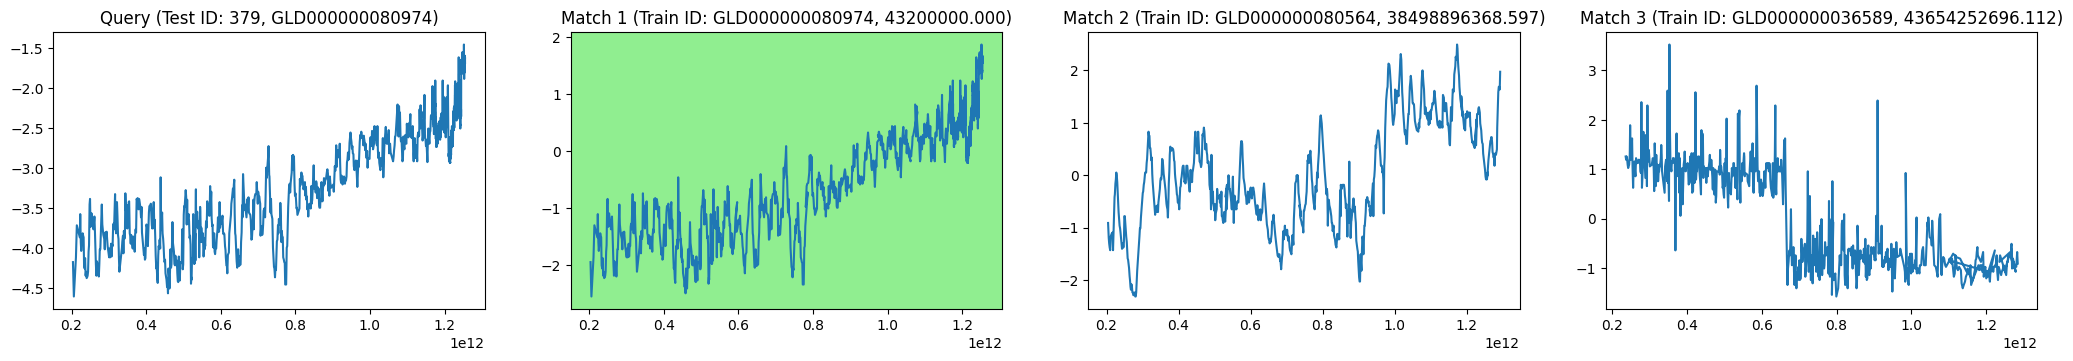

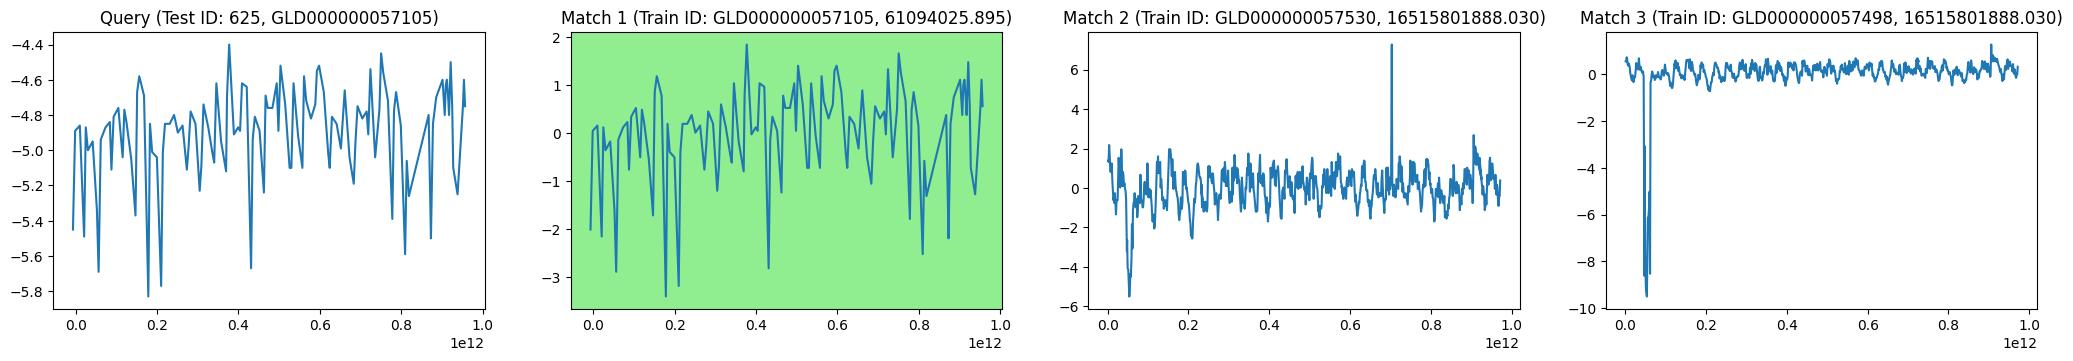

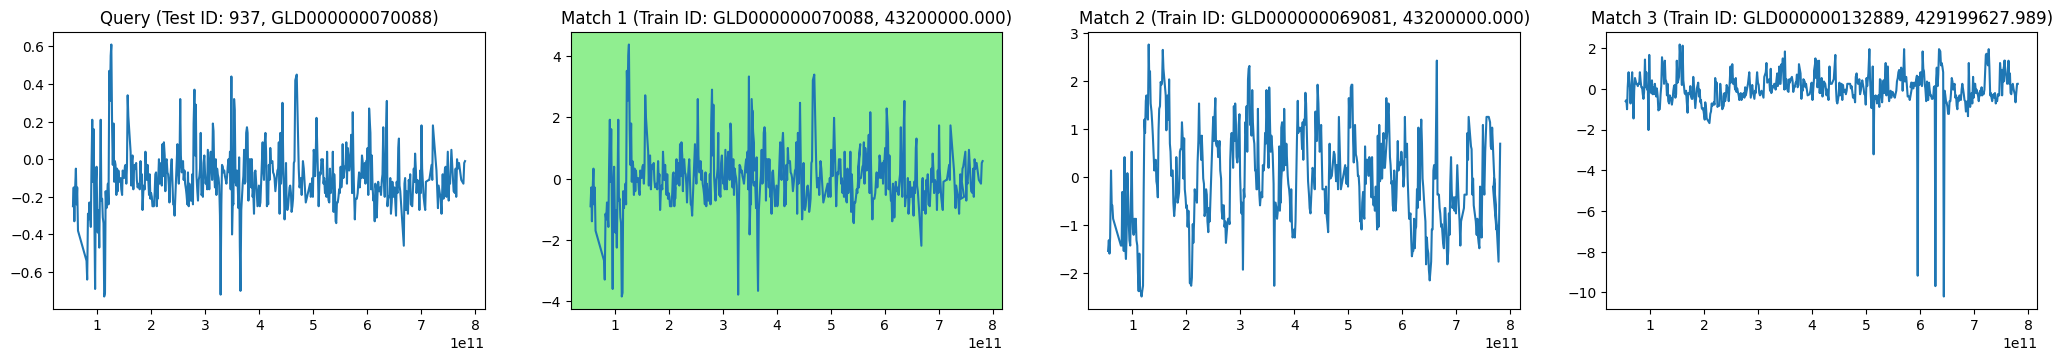

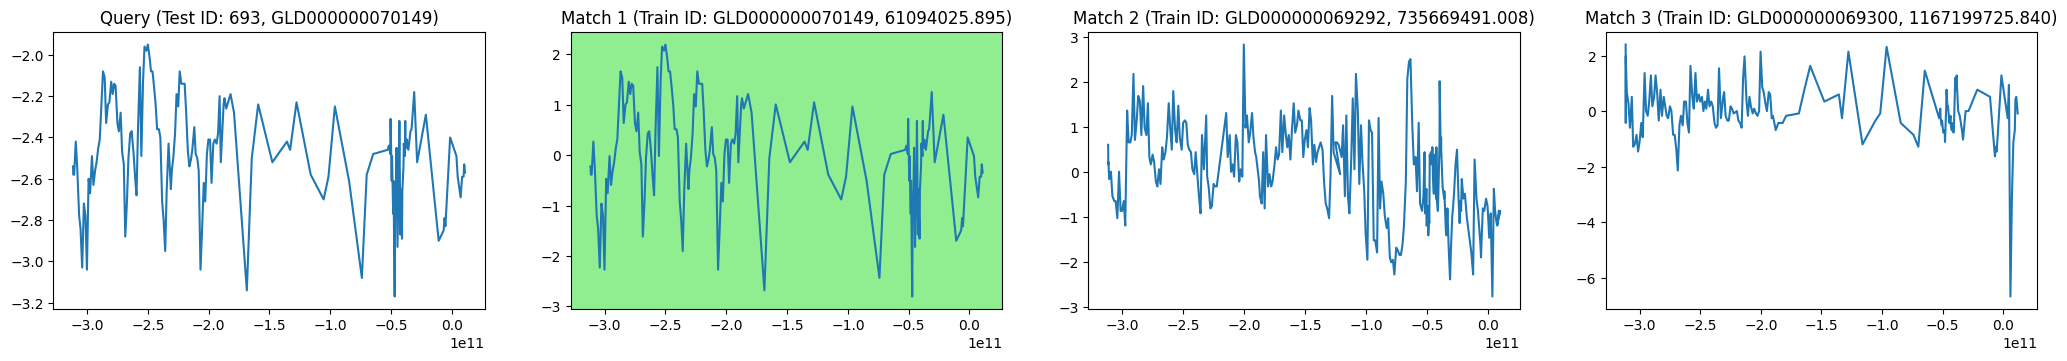

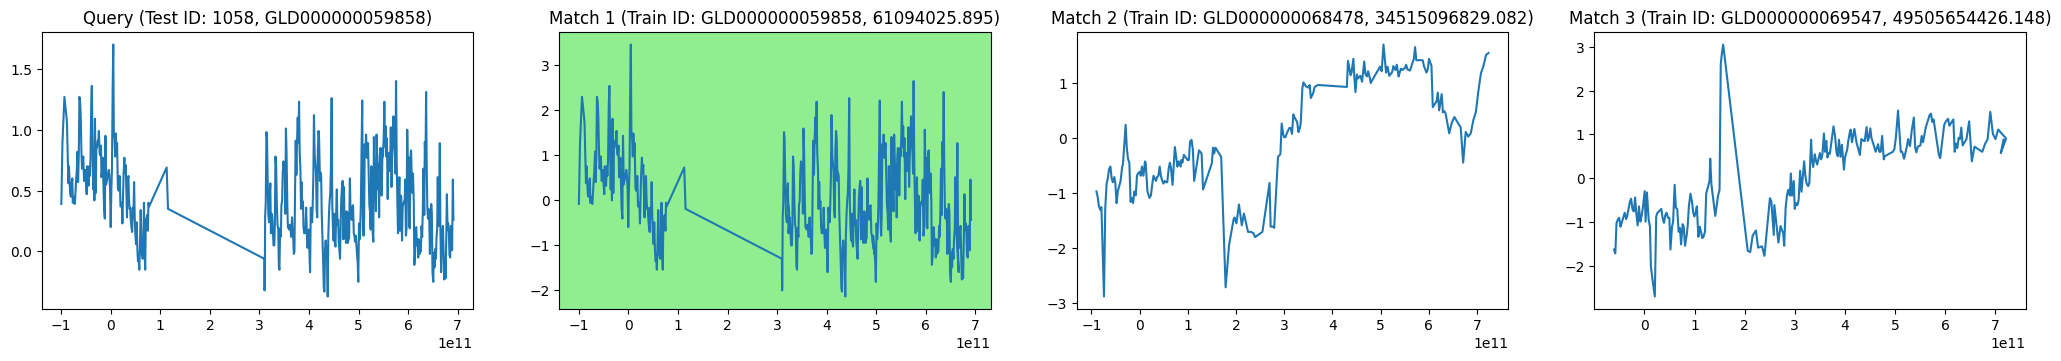

In [23]:
import matplotlib.pyplot as plt
n_plots = 5
selected_indices = np.random.choice(len(fingerprint_dino.keys()), size=n_plots, replace=False)
    
# plotting loop: one query + top-k matches per selected sample
for i in selected_indices:
    gld = list(fingerprint_bro.keys())[i]
    neighs = indices[i][:k]
    distances = dists[i][:k]
    label = label_test[i]
    neigh_labels = retrieved_label[i]

    n_cols = 1 + k
    fig, ax = plt.subplots(1, n_cols, figsize=(6.4 * n_cols, 3.6))
    # query (BRO, unseen)
    ax[0].plot(data_obs[gld]["bro"][:,0], data_obs[gld]["bro"][:,1])
    ax[0].set_title(f"Query (Test ID: {i}, {gld})")
    # predictions (DINO, seen)
    for j, (n_idx, n_label, dist) in enumerate(zip(neighs, neigh_labels, distances), start=1):
        ax[j].plot(data_obs[n_label]["dino"][:,0], data_obs[n_label]["dino"][:,1])
        ax[j].set_title(f"Match {j} (Train ID: {n_label}, {dist:.3f})")
        if label == n_label: ax[j].set_facecolor("lightgreen")

## Further exploration
- If needed faster implementarion of Lom-Scargle periodogram calculation, consider the [Astropy implementation](https://docs.astropy.org/en/stable/timeseries/lombscargle.html).
- For the fingerprints, we've considered the features without any sort of normalization (coordinates, time-features) this could also be included to diminish the weight of differences in these features.